# Predicting Log Error from Zillow's Zestimate


In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import math

import acquire
import explore

from sklearn.cluster import KMeans

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

## Acquiring the Data
A dataframe is acquired from Codeup's SQL zillow database using the `prepare_zillow()` function from acquire.py. 

`prepare_zillow()` returns a dataframe split into train, validate, and test based on the requirements detailed in the README.

In summary:
1. Data was obtained from Codeup's SQL database.
2. Categorical variables encoded as numeric data types are converted to object type.
3. fips codes were converted into county names.
4. Outliers were compressed (excluding log error).
5. Missing values were dropped or imputed with the mean, median, or mode.

In [2]:
train, validate, test = acquire.prepare_zillow()

In [3]:
#Observe the size of each set
train.shape, validate.shape, test.shape

((52518, 25), (13130, 25), (7295, 25))

In [4]:
train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
48285,2.0,2.0,4.000000,1170.0,Los Angeles,2.0,7.0,33876919.0,-118405108.0,2258.0,...,1916.0,38403.0,294146.0,255743.0,3376.55,6.03762e+13,0.163588,2017-06-27,Floor/Wall,Single Family Residential
4918,3.0,2.0,7.000000,1827.0,Los Angeles,3.0,2.0,33765300.0,-118172000.0,15018.0,...,1970.0,360413.0,604073.0,243660.0,7207.01,6.03758e+13,0.049248,2017-01-25,Central,Condominium
14238,3.0,3.0,8.000000,1949.0,Los Angeles,3.0,2.0,34111771.0,-117748974.0,3317.0,...,1980.0,106726.0,177748.0,71022.0,2210.76,6.0374e+13,0.041176,2017-03-07,Central,Planned Unit Development
33467,3.0,4.0,6.639845,1835.0,Ventura,3.0,2.0,34181577.0,-118953714.0,6098.0,...,1974.0,160407.0,267340.0,106933.0,2801.20,6.11101e+13,0.089397,2017-05-11,Central,Condominium
22026,3.0,3.0,4.000000,1287.0,Los Angeles,3.0,2.0,33802256.0,-118187611.0,6255.0,...,1922.0,159987.0,338075.0,178088.0,4171.91,6.03757e+13,0.035123,2017-04-04,Central,Single Family Residential


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52518 entries, 48285 to 12816
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   52518 non-null  float64
 1   bedroomcnt                    52518 non-null  float64
 2   buildingqualitytypeid         52518 non-null  float64
 3   calculatedfinishedsquarefeet  52518 non-null  float64
 4   fips                          52518 non-null  object 
 5   fullbathcnt                   52518 non-null  float64
 6   heatingorsystemtypeid         52518 non-null  float64
 7   latitude                      52518 non-null  float64
 8   longitude                     52518 non-null  float64
 9   lotsizesquarefeet             52518 non-null  float64
 10  propertycountylandusecode     52518 non-null  object 
 11  propertylandusetypeid         52518 non-null  object 
 12  rawcensustractandblock        52518 non-null  object 
 1

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroomcnt,52518.0,2.288606e+00,0.945545,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.000000e+00
bedroomcnt,52518.0,3.023021e+00,1.001980,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.000000e+01
buildingqualitytypeid,52518.0,6.639845e+00,1.351593,1.000000e+00,6.000000e+00,6.639845e+00,7.000000e+00,1.200000e+01
calculatedfinishedsquarefeet,52518.0,1.758181e+03,903.319191,1.520000e+02,1.174000e+03,1.524000e+03,2.074000e+03,7.495000e+03
fullbathcnt,52518.0,2.219334e+00,0.928838,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.000000e+00
heatingorsystemtypeid,52518.0,3.237995e+00,3.052119,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.400000e+01
latitude,52518.0,3.400924e+07,269800.378244,3.333953e+07,3.381096e+07,3.402277e+07,3.417770e+07,3.481240e+07
longitude,52518.0,-1.181983e+08,361368.221699,-1.194484e+08,-1.184198e+08,-1.181687e+08,-1.179174e+08,-1.175575e+08
lotsizesquarefeet,52518.0,1.294979e+04,14041.788327,2.360000e+02,5.999000e+03,7.290500e+03,1.088775e+04,5.129950e+04
yearbuilt,52518.0,1.969847e+03,23.036533,1.878000e+03,1.954000e+03,1.971000e+03,1.987000e+03,2.016000e+03


## Exploration
The goal of this project is to identify drivers of log error. Ideally, we develop a model that is able to predict log error. We will investigate this data through a series of questions.

### Q1. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

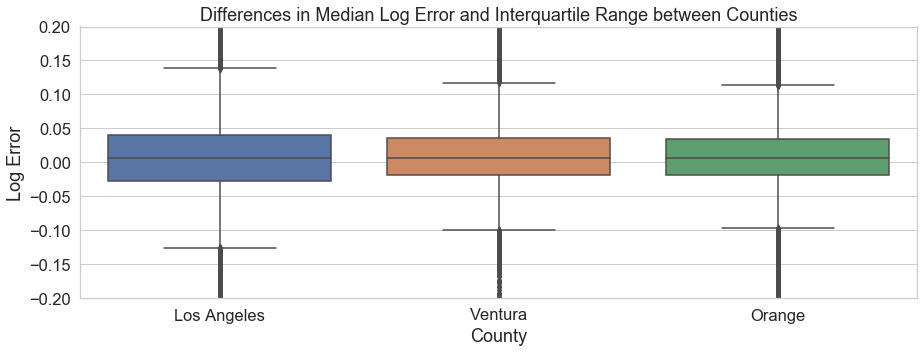

In [7]:
sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(15,5))
plt.ylim(-.2, .2) # Range of y-axis is trimmed to better visualize IQR
sns.boxplot(data=train, x=train.fips, y=train.logerror)
plt.title('Differences in Median Log Error and Interquartile Range between Counties')
plt.xlabel('County')
plt.ylabel('Log Error')
plt.show()

In [8]:
train.groupby('fips').logerror.describe()

,count,mean,std,min,25%,50%,75%,max
fips,,,,,,,,
Los Angeles,33916.0,0.013910,0.151394,-4.655420,-0.026780,0.006472,0.039737,3.394544
Orange,14447.0,0.020867,0.187606,-2.406257,-0.018078,0.006907,0.034739,2.933328
Ventura,4155.0,0.016276,0.159583,-2.922919,-0.018415,0.006452,0.036050,2.311174


We can use a one-way Anova to determine if there is a meaningful difference in these means. The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

1. The samples are independent. (Appears to be True)
2. Each sample is from a normally distributed population. (Appears to be True)
3. The standard deviations of the groups are all equal. (Appears to be True)

There might be some minor violation of these assumptions, but if our p-value is low enough, we can be confident in our evaluation. 

$H_0$: There is no difference between the mean log error of these counties.

$H_a$: At least one of these counties has a mean log error that is different from at least one other counties mean log error.

In [9]:
alpha = 0.05
F, p = stats.f_oneway(train.logerror[train.fips == 'Los Angeles'], train.logerror[train.fips == 'Orange'], train.logerror[train.fips == 'Ventura'])
F, p

(9.257558206936508, 9.554371845955292e-05)

In [10]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


Performance of the Kruskal-Wallis test further solidifies our case

$H_0$: There is no difference between the median log error of these counties

$H_a$: At least one of these counties has a median log error that is different from at least one other counties median log error.

In [11]:
alpha = 0.05
H, p = stats.kruskal(train.logerror[train.fips == 'Los Angeles'], train.logerror[train.fips == 'Orange'], train.logerror[train.fips == 'Ventura'])
H, p

(15.284584916994751, 0.0004797274352874927)

In [12]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Takeaways:
There is some difference in Zestimate's ability to predict based on the fips county location data. This location data may be a good candidate for a model feature.

### Q2. Is there a relationship between tax assessed property values and log error?

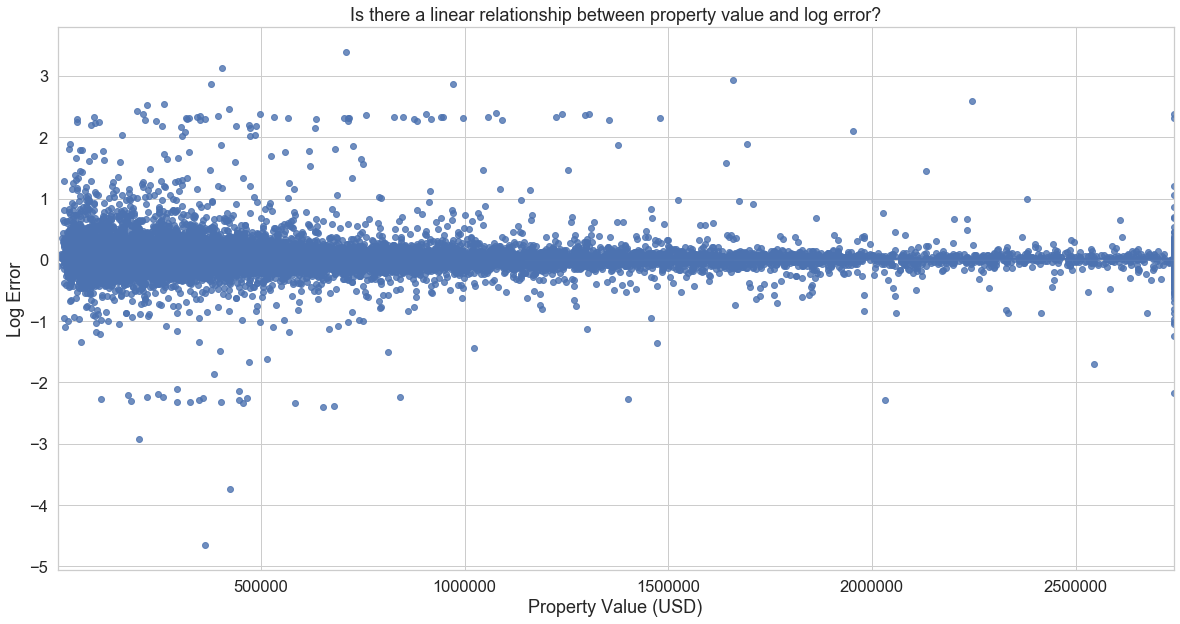

In [13]:
plt.figure(figsize=(20,10))
sns.regplot(data=train, x=train.taxvaluedollarcnt, y= train.logerror)
plt.title('Is there a linear relationship between property value and log error?')
plt.xlabel('Property Value (USD)')
plt.ylabel('Log Error')
plt.show()

Visual inspection of a scatterplot with line of best fit demonstrates that there is no linear relationship between log error and property value, but it appears that the variance of the logerror increases as property value decreases. We can look at this in more detail.

Let's begin by creating a variable absolute_logerror that is the absolute value of the logerror for each observation. Then we can see if there is a linear relationship between absolute logerror and property value.

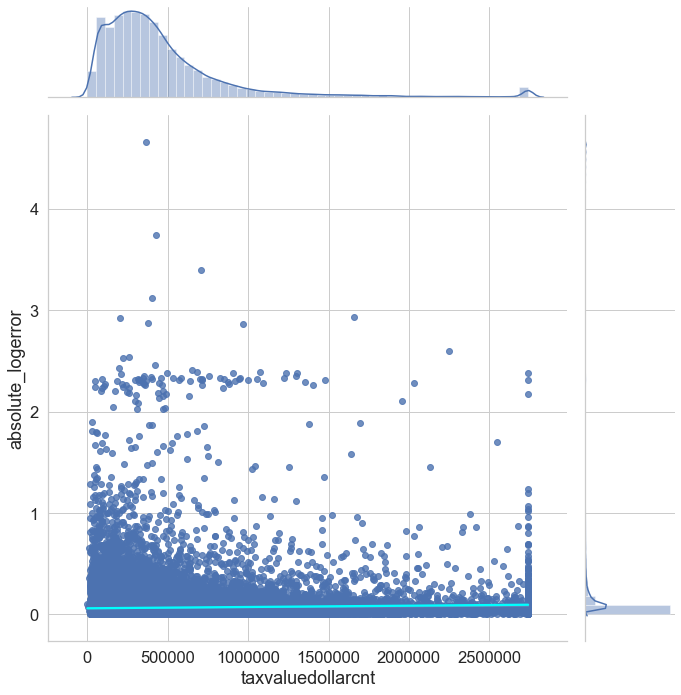

In [14]:
train['absolute_logerror'] = abs(train.logerror) #Creates a new column made only of absolute log error values
g = sns.jointplot(height = 10, x="taxvaluedollarcnt", y="absolute_logerror", data=train, kind='reg',
                  joint_kws={'line_kws':{'color':'cyan'}}) # Colors the regression line cyan for visibility

This doesn't look too promising. The line of best fit is accommodating the compressed upper outliers and appears to be relatively flat overall. Perhaps a better approach will be to bin the data and see if there are meaningful differences between parts of the distribution. 

Text(0, 0.5, 'Log Error')

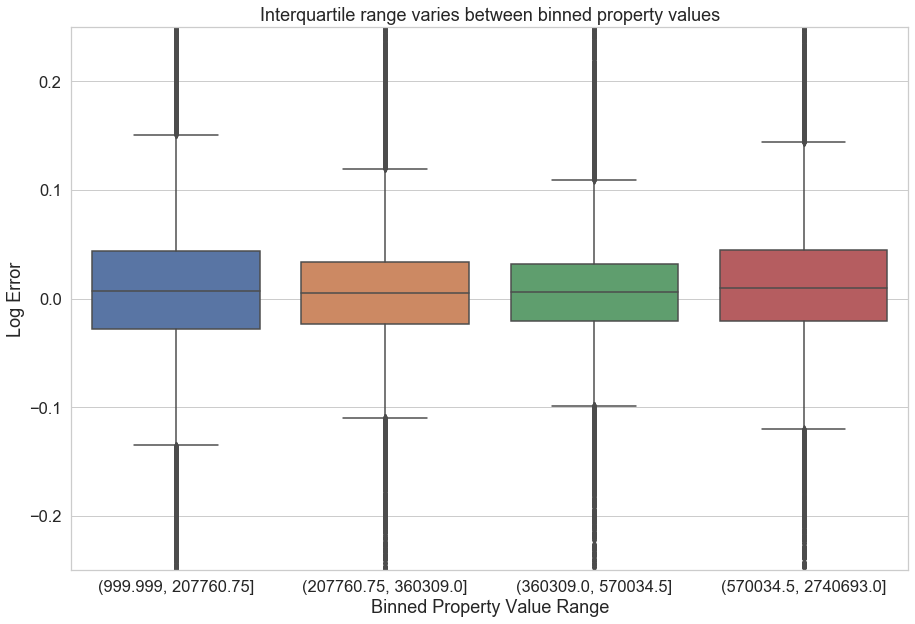

In [15]:
train['binned_value'] = pd.qcut(train['taxvaluedollarcnt'], q=4) #Creates a categorical bin for each quartile
plt.figure(figsize=(15, 10))
plt.ylim(-.25, .25)
sns.boxplot(data=train, x='binned_value', y='logerror')
plt.title('Interquartile range varies between binned property values')
plt.xlabel('Binned Property Value Range')
plt.ylabel('Log Error')

Visual inspection appears to show that there are differences in the interquartile ranges between the binned property value groups.

In [16]:
train.groupby('binned_value').logerror.describe()

,count,mean,std,min,25%,50%,75%,max
binned_value,,,,,,,,
"(999.999, 207760.75]",13130.0,0.021265,0.167731,-2.922919,-0.027911,0.006704,0.043596,2.426789
"(207760.75, 360309.0]",13130.0,0.014490,0.149805,-2.312395,-0.023628,0.004606,0.033694,2.536896
"(360309.0, 570034.5]",13128.0,0.010866,0.146687,-4.655420,-0.020675,0.005679,0.031326,3.123634
"(570034.5, 2740693.0]",13130.0,0.017423,0.184069,-2.406257,-0.021026,0.009958,0.045024,3.394544


There appear to be differences in the means between these groups. We can confirm this with a one-way anova.

$H_0$: There is no difference in the mean log error of these property value quartiles

$H_a$: There is at least one mean log error that differs from on other mean log error within these property value quartiles.

In [17]:
alpha = 0.05
#Compares the mean log error of each binned quartile with the mean log error of the other bins
F, p = stats.f_oneway(train.logerror[train.binned_value.isin((999.999, 207760.75))], 
                      train.logerror[train.binned_value.isin((207760.75, 360309.0))], 
                      train.logerror[train.binned_value.isin((360309.0, 570034.5))],
                      train.logerror[train.binned_value.isin((570034.5, 2740693.0))])
F, p

(10.91553392859798, 3.652443823239081e-07)

In [18]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Takeaways:
- We do not yet know specifically which quartiles are different from each other, but at least one pair of them is different.
- There appears to be a lot of value in binning these property values. The value of categorizing records into bins may be improved through the use of k-means clustering. 

### Q3. Which variables have the highest correlation with logerror?

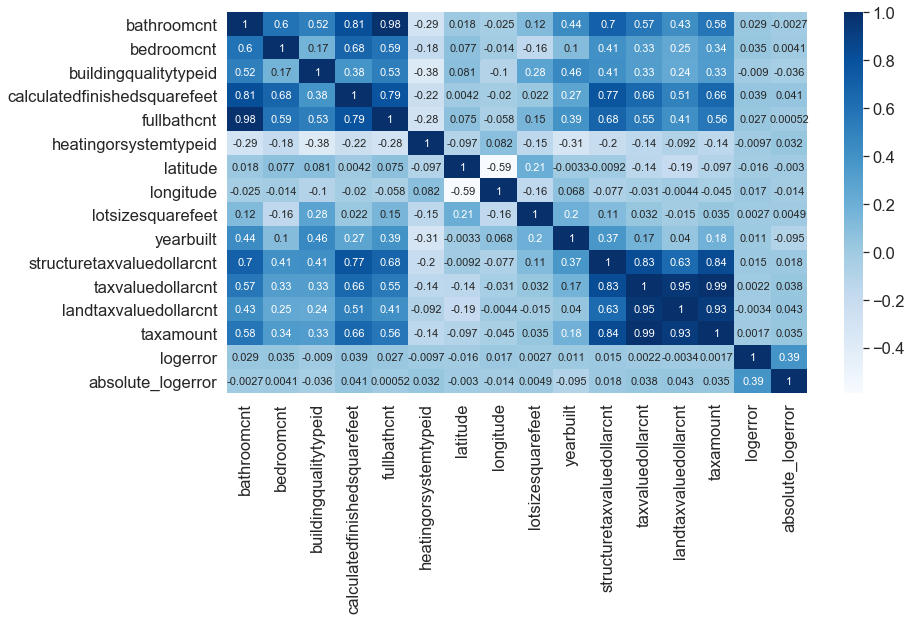

In [19]:
#This function creates a correlation plot of only the numeric data types
explore.corr_plot(train)

There do not appear to be many strong linear correlations between any of the numeric variables and logerror. As we saw earlier however, the lack of a linear correlation does not mean that there is no relationship. We may be able to magnify some of these interactions through clustering techniques. We can review a pairplot to see the interactions between these variables.

### Q4. Are there any relationships between variables that can not be described by the presence or absence of a linear correlation?

There is quite a bit of collinearity between some of the variables used in the correlation plot because they represent the same characteristics (ex: `fullbathcount` and `bathroomcnt`). At this point, its more useful to look at the interactions of features that do not have such a high degree of collinearity. 

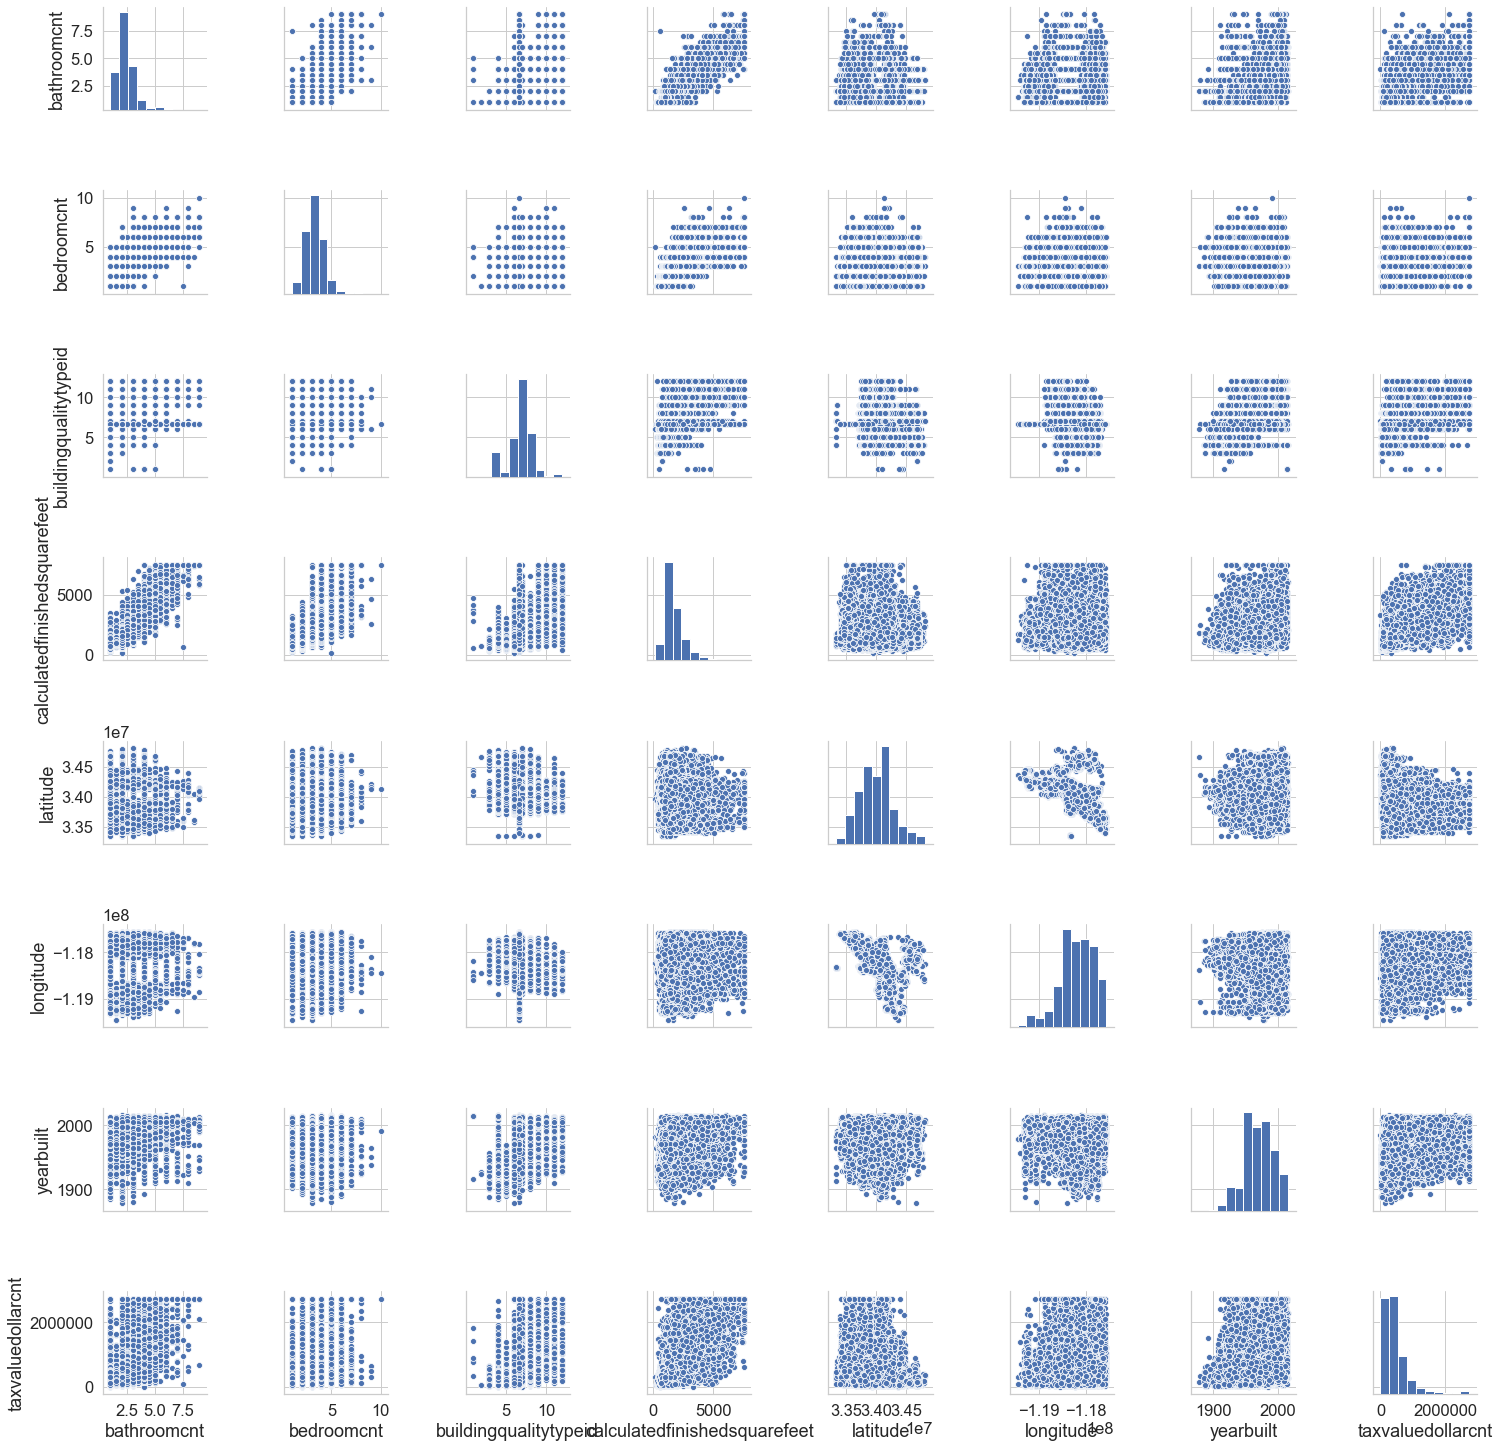

In [20]:
pairs = train[['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', 'yearbuilt', 'taxvaluedollarcnt']]
sns.pairplot(pairs)

#### Takeaways
- The goal of the pairplot is to identify possible candidates for K-Means Clustering models.
- There are a number of visual relationships that match the general correlation value given in the corrplot above (number of bathrooms and square footage for example appear to take a general positive linear relationship)
- There are other relationships that are not explained through a simple linear correlation.
    - Building quality tends to increase with property value, but there a distinction between low quality homes and higher quality homes. It appears that once you reach at least a quality above 5, the influence on building quality and property value becomes negligible. 
    - Year built and property value area also positively correlated, but it is only the very old homes (1930 and older) that appear to show the most meaningful relationship with property value.
    - Very old homes also appear to have less variance in the number of bedrooms and bathrooms. Older homes tend to have 3 or fewer bathrooms and 5 or fewer bedrooms. Newer homes can have any combination of both across larger ranges. 
    - Buildings of low quality tend to have very few bathrooms. There is a similar pattern in bedrooms but it is not as distinct. 
    - There is some correlation between latitude/longitude and property value, but the relationship between latitude/longitude and other variables are quite weak, suggesting that homes across various latitudes and longitudes tend to not be that different from each other structurally, but are more or less valuable because of neighborhood considerations (like school district quality, crime rates, etc.). 
    
    
- **The relationships that are not as easily explained by simple linear correlation are the ones that may be the most valuable to include in clustering models**

### Q5. Are there clusters of data that have significantly different means of log error?
To begin clustering, we will need to scale the data. We will drop `absolute_logerror` as it was derived from our target variable and so will not be used in any modeling. `binned_value` will also be dropped for the purposes of scaling this data, as categories cannot be scaled. 

In [21]:
train.drop(columns=['absolute_logerror', 'binned_value'], inplace=True)
scaler, train_scaled, validate_scaled, test_scaled = explore.standard_scaler(train, validate, test)

In [22]:
train_scaled.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror
48285,-0.305230,-1.021009,-1.953154,-0.651140,-0.236141,1.232600,-0.490431,-0.572280,-0.761434,-2.337494,-0.876399,-0.402275,-0.102345,-0.467068,0.906449
4918,0.752371,-1.021009,0.266469,0.076185,0.840484,-0.405622,-0.904145,0.072797,0.147291,0.006631,1.071890,0.299497,-0.140073,0.279581,0.204150
14238,0.752371,-0.022975,1.006344,0.211244,0.840484,-0.405622,0.380043,1.243431,-0.686016,0.440728,-0.463018,-0.665836,-0.679111,-0.694309,0.154567
33467,0.752371,0.975058,0.000000,0.085041,0.840484,-0.405622,0.638777,-2.090430,-0.487962,0.180270,-0.138226,-0.462972,-0.566984,-0.579218,0.450750
22026,0.752371,-0.022975,-1.953154,-0.521616,0.840484,-0.405622,-0.767168,0.029597,-0.476781,-2.077036,-0.140767,-0.302806,-0.344812,-0.312034,0.117389


The goal is to identify three different clustering algorithms to see which has the most significant difference in their mean log error. Based on the scaled factors we have available, and the previous evaluation of the pairplot, the K-Means algorithm will be driven by the following sets of factors:

1. `bathroomcnt`, `bedroomcnt`, `calculatedfinishedsquarefeet` - This set is based on the relative importance of these factors individually.  
2. `buildingqualitytypeid`, `taxvaluedollarcnt`, `yearbuilt` - This set is based on the pattern that homes that achieve a certain threshold building quality score tend to have greater variance in the property value. Year built has a relationship with both variables. It will be included to further refine observation distance. 
3. `buildingqualitytypeid`, `bathroomcnt`, `taxvaluedollarcnt` - This set is made of parts of the previous two sets.  

### Cluster Set 1: `bathroomcnt`, `bedroomcnt`, `calculatedfinishedsquarefeet`

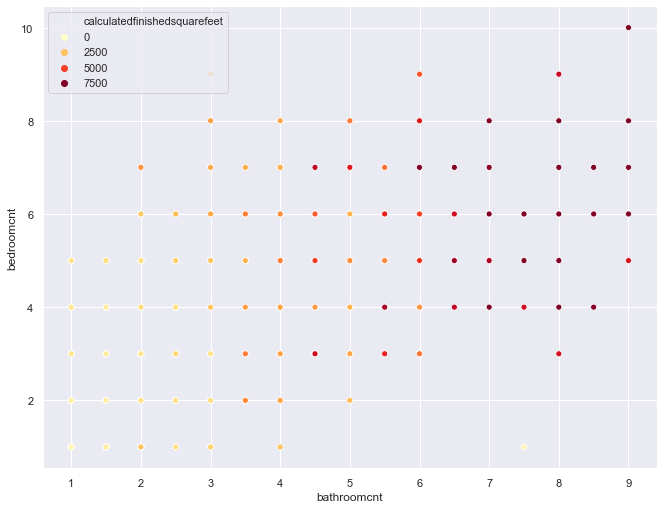

In [23]:
#Visualizing Set #1
sns.set(rc={'figure.figsize':(11,8.5)})
sns.scatterplot(data=train, x='bathroomcnt', y='bedroomcnt', hue='calculatedfinishedsquarefeet', palette='YlOrRd')
plt.show()

As expected, all three factors move in tandem. As any one increases, so do the other two. 

In [24]:
#Creating the dataframe for the first clustering set
X1 = train_scaled[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]

#Creating and fitting the model on the scaled training data
kmeans1 = KMeans(n_clusters=3)
kmeans1.fit(X1)

#Adding the results of the model to the unscaled train dataframe
train['cluster1'] = kmeans1.predict(X1)
train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,cluster1
48285,2.0,2.0,4.000000,1170.0,Los Angeles,2.0,7.0,33876919.0,-118405108.0,2258.0,...,38403.0,294146.0,255743.0,3376.55,6.03762e+13,0.163588,2017-06-27,Floor/Wall,Single Family Residential,1
4918,3.0,2.0,7.000000,1827.0,Los Angeles,3.0,2.0,33765300.0,-118172000.0,15018.0,...,360413.0,604073.0,243660.0,7207.01,6.03758e+13,0.049248,2017-01-25,Central,Condominium,0
14238,3.0,3.0,8.000000,1949.0,Los Angeles,3.0,2.0,34111771.0,-117748974.0,3317.0,...,106726.0,177748.0,71022.0,2210.76,6.0374e+13,0.041176,2017-03-07,Central,Planned Unit Development,0
33467,3.0,4.0,6.639845,1835.0,Ventura,3.0,2.0,34181577.0,-118953714.0,6098.0,...,160407.0,267340.0,106933.0,2801.20,6.11101e+13,0.089397,2017-05-11,Central,Condominium,0
22026,3.0,3.0,4.000000,1287.0,Los Angeles,3.0,2.0,33802256.0,-118187611.0,6255.0,...,159987.0,338075.0,178088.0,4171.91,6.03757e+13,0.035123,2017-04-04,Central,Single Family Residential,0


In [25]:
train.cluster1.value_counts()

0    28697
1    17232
2     6589
Name: cluster1, dtype: int64

Although the bulk of the observations are found in cluster 0, there is a large enough proportion in the remaining clusters to suggest that the division is meaningful.

In [26]:
train.groupby('cluster1').mean()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror
cluster1,,,,,,,,,,,,,,,
0,2.402533,3.284420,6.803133,1746.715963,2.330348,2.748232,3.403175e+07,-1.181998e+08,11743.206607,1971.342049,167034.449733,4.332593e+05,265768.702617,5345.688603,0.015204
1,1.489844,2.035399,6.039146,1096.501683,1.442839,4.451602,3.397207e+07,-1.181885e+08,14519.345723,1962.709374,107626.472551,3.102051e+05,202614.075659,3842.701975,0.011353
2,3.881393,4.467446,7.499669,3538.585066,3.766581,2.197147,3.400838e+07,-1.182176e+08,14100.039839,1982.004437,451671.604948,1.062307e+06,612285.331348,12679.959111,0.031710


#### Set 1 Cluster Descriptions:
**Type 0** - The largest group of observations are moderate in nearly every feature. Smaller than Type 2, but larger than Type 1. Built earlier than Type 2, but later than Type 1. They have higher property values than Type 1 homes, but have lower values than Type 2 homes. 

**Type 1** - These are smaller, older homes with lower quality scores and the lower property values to show for it. 

**Type 2** - These are large homes with a high number of bedrooms and bathrooms, which is to be expected of larger homes. They have been built more recently than the other clusters, and are worth quite a bit more. 



In [27]:
train.groupby('cluster1').logerror.describe()

,count,mean,std,min,25%,50%,75%,max
cluster1,,,,,,,,
0,28697.0,0.015204,0.151774,-4.655420,-0.021803,0.006177,0.035181,2.876386
1,17232.0,0.011353,0.164851,-2.922919,-0.028240,0.003959,0.035980,3.123634
2,6589.0,0.031710,0.198945,-2.406257,-0.015691,0.015869,0.057234,3.394544


Looking at log error between the clusters, we see that the larger, more valuable homes have the highest log mean log error overall (almost twice as much as the more common cluster type 0 homes!). 

In [28]:
train.logerror.mean()

0.016011291987422068

Considering the overall mean log error, it appears that logerror is being primarily driven by Type 2 homes. 

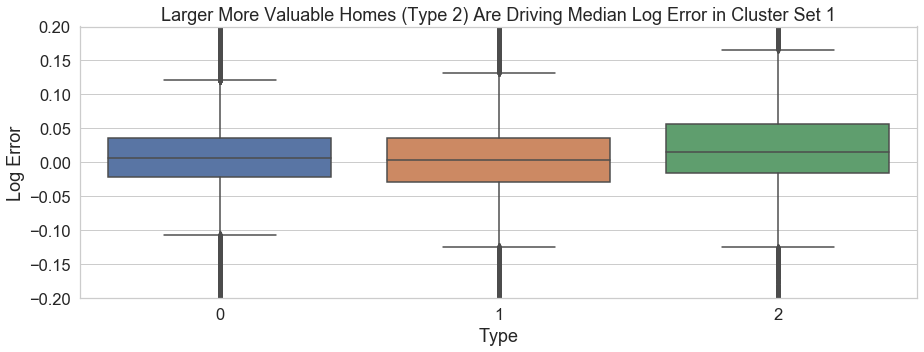

In [51]:
sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(15,5))
plt.ylim(-.2, .2) # Range of y-axis is trimmed to better visualize IQR
sns.boxplot(data=train, x=train.cluster1, y=train.logerror)
plt.title('Larger More Valuable Homes (Type 2) Are Driving Median Log Error in Cluster Set 1')
plt.xlabel('Type')
plt.ylabel('Log Error')
plt.show()

From visual inspection, we can see larger differences in median log error compared to our first two categorical comparisons using county and then property value. Type two homes appear to have both a higher median and interquartile range than the other types. 

#### Validation through Statistical Testing
A combination of anova, kruskal-wallis, and t-tests will support the claim that it is 2 type homes that are driving the log error.

#### ANOVA

$H_0$: There is no difference in the mean log errors of the three property types

$H_a$: There is at least one mean log error that is different from one other mean log error within the three property types.

In [30]:
alpha = 0.05
F, p = stats.f_oneway(train.logerror[train.cluster1 == 0], train.logerror[train.cluster1 == 1], train.logerror[train.cluster1 == 2])
F, p

(38.0917344399802, 2.944135638756828e-17)

In [31]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Kruskal-Wallis

$H_0$: There is no difference in the median log errors of the three property types

$H_a$: There is at least one median that is different from one other median within the three property types.

In [32]:
alpha = 0.05
H, p = stats.kruskal(train.logerror[train.cluster1 == 0], train.logerror[train.cluster1 == 1], train.logerror[train.cluster1 == 2])
H, p

(312.1917828388091, 1.6159045684700288e-68)

In [33]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


We have identified that there is at least one significant difference present among the three groups.

#### T-Test
Each mean will be compared to each other mean.

- **Type 0 and Type 1**

$H_0$: There is no difference between the mean log error of Type 0 homes and the mean log error of Type 1 homes.

$H_a$: Type 0 homes have a **larger** mean log error than Type 1 homes.

In [47]:
T, p = stats.ttest_ind(train.logerror[train.cluster1 == 0], train.logerror[train.cluster1 == 1])
T, p/2

(2.548705630102014, 0.005407788228558276)

In [35]:
if p/2 < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


- **Type 0 and Type 2**

$H_0$: There is no difference between the mean log error of Type 0 homes and the mean log error of Type 2 homes.

$H_a$: Type 2 have a **larger** mean log error than Type 0

In [48]:
T, p = stats.ttest_ind(train.logerror[train.cluster1 == 2], train.logerror[train.cluster1 == 0])
T, p/2

(7.475461567420698, 3.935726104182515e-14)

In [37]:
if p/2 < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


- **Type 1 and Type 2**

$H_0$: There is no difference between the mean log error of Type 1 homes and the mean log error of Type 2 homes.

$H_a$: Type 1 homes hava a **smaller** mean log error than Type 2 homes. 

In [38]:
T, p = stats.ttest_ind(train.logerror[train.cluster1 == 1], train.logerror[train.cluster1 == 2])
T, p/2

(-8.033641866357318, 4.948734881305545e-16)

In [39]:
if p/2 < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Takeways:
- All of the samples have mean log errors that are significantly different from each other. 

        Type 2 (big, expensive homes) > Type 0 (moderate homes) > Type 1 (small, inexpensive homes)

### Cluster Set 2: `buildingqualitytypeid`, `taxvaluedollarcnt`, `yearbuilt`

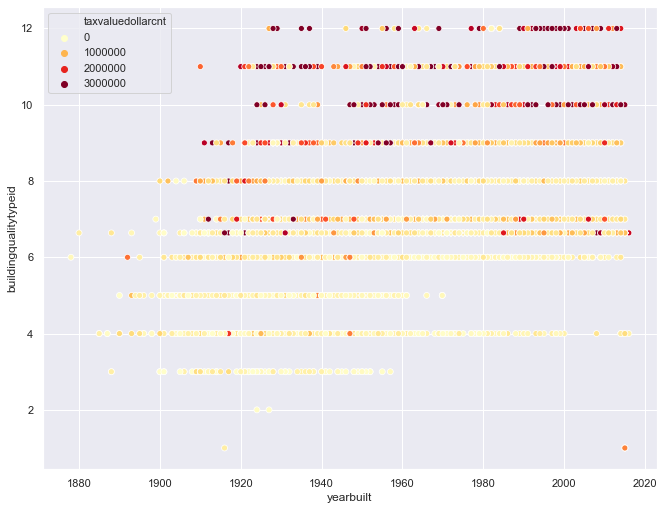

In [40]:
#Visualizing Set #1
sns.set(rc={'figure.figsize':(11,8.5)})
sns.scatterplot(data=train, x='yearbuilt', y='buildingqualitytypeid', hue='taxvaluedollarcnt', palette='YlOrRd')
plt.show()

From visual inspection, it appears that property value is more dependent on the building quality than the year the property was built, but there are virtually no high value properties prior to 1915. At the same time, there are virtually no properties with high building quality prior to 1915, so the relationship may still be driven by building quality more than year built.

In [41]:
#Creating the dataframe for the second clustering set
X2 = train_scaled[['yearbuilt', 'buildingqualitytypeid', 'taxvaluedollarcnt']]

#Creating and fitting the model on the scaled training data
kmeans2 = KMeans(n_clusters=3)
kmeans2.fit(X2)

#Adding the results of the model to the unscaled train dataframe
train['cluster2'] = kmeans2.predict(X2)
train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,...,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,cluster1,cluster2
48285,2.0,2.0,4.000000,1170.0,Los Angeles,2.0,7.0,33876919.0,-118405108.0,2258.0,...,294146.0,255743.0,3376.55,6.03762e+13,0.163588,2017-06-27,Floor/Wall,Single Family Residential,1,0
4918,3.0,2.0,7.000000,1827.0,Los Angeles,3.0,2.0,33765300.0,-118172000.0,15018.0,...,604073.0,243660.0,7207.01,6.03758e+13,0.049248,2017-01-25,Central,Condominium,0,1
14238,3.0,3.0,8.000000,1949.0,Los Angeles,3.0,2.0,34111771.0,-117748974.0,3317.0,...,177748.0,71022.0,2210.76,6.0374e+13,0.041176,2017-03-07,Central,Planned Unit Development,0,1
33467,3.0,4.0,6.639845,1835.0,Ventura,3.0,2.0,34181577.0,-118953714.0,6098.0,...,267340.0,106933.0,2801.20,6.11101e+13,0.089397,2017-05-11,Central,Condominium,0,1
22026,3.0,3.0,4.000000,1287.0,Los Angeles,3.0,2.0,33802256.0,-118187611.0,6255.0,...,338075.0,178088.0,4171.91,6.03757e+13,0.035123,2017-04-04,Central,Single Family Residential,0,0


In [43]:
train.cluster2.value_counts()

1    33127
0    15829
2     3562
Name: cluster2, dtype: int64

While not as evenly partitioned as cluster1, there are still enough values in each group to investigate their characteristics. 

In [44]:
train.groupby('cluster2').mean()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,cluster1
cluster2,,,,,,,,,,,,,,,,
0,1.651399,2.843894,5.301430,1345.029819,1.643692,4.800051,3.403339e+07,-1.182146e+08,7752.769505,1944.821545,96513.930728,3.028401e+05,2.065313e+05,3873.038392,0.016212,0.536800
1,2.426555,3.016301,7.121137,1769.242944,2.332870,2.601775,3.400484e+07,-1.181842e+08,15098.466387,1981.105594,181066.528089,4.151764e+05,2.341223e+05,5103.363616,0.015081,0.518610
2,3.837310,3.881527,8.111491,3491.289725,3.721505,2.213363,3.394279e+07,-1.182567e+08,16061.719118,1976.353929,589040.229787,1.749306e+06,1.158789e+06,20439.490632,0.023770,1.328748


#### Set 2 Cluster Descriptions:
**Type 0** - These homes have the fewest bedrooms and bathrooms, the smallest square footage, and are decades older than the other clusters. They also have substantially lower structure values, and moderately land values. A greater proportion of the overall value of the property appears to be coming from the land. 

**Type 1** - This represents the greatest proportion of homes. Mid range in the number of bathrooms, number of bedrooms, and only slightly 20% more square footage than Type 0 homes. Taxes and property values are about 30% higher.  

**Type 2** - Although there are very few of these homes, these are substantially larger and more valuable than the others. The taxes assessed on these property are about 4 times larger than Type 1 homes and 5 times larger than Type 0 homes. Compared to the "large, valuable" homes in Set 1, these homes are "extravagant". 

In [45]:
train.groupby('cluster2').logerror.describe()

,count,mean,std,min,25%,50%,75%,max
cluster2,,,,,,,,
0,15829.0,0.016212,0.169125,-2.271428,-0.032945,0.005076,0.042654,2.523992
1,33127.0,0.015081,0.151637,-4.655420,-0.019578,0.006386,0.033683,3.394544
2,3562.0,0.023770,0.223193,-2.283534,-0.025918,0.019769,0.065376,2.933328


We see in this set of clusters as we saw in the first set. Larger more valuable homes (Type 2) have the greatest mean log error with the greatest standard deviation. However, compared to the first set of clusters, the differences between these three types are not as pronounced. 

In [49]:
train.logerror.mean()

0.016011291987422068

Based on this cluster, its not quite as strong of a case for asserting that larger more valuable homes (at least as defined by Set 2 Type 2) are driving the log error, but the mean is still being driven higher by them compared to the other types. 

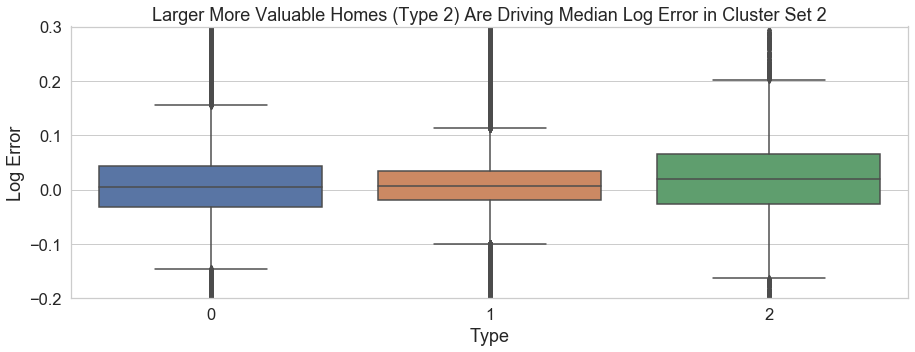

In [53]:
sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(15,5))
plt.ylim(-.2, .3) # Range of y-axis is trimmed to better visualize IQR
sns.boxplot(data=train, x=train.cluster2, y=train.logerror)
plt.title('Larger More Valuable Homes (Type 2) Are Driving Median Log Error in Cluster Set 2')
plt.xlabel('Type')
plt.ylabel('Log Error')
plt.show()

From visual inspection, we again see that larger homes have higher median log error. Within this set, Type 1 homes (moderately sized and valued) a much smaller interquartile range than the others. 

#### Validation through Statistical Testing
A combination of anova, kruskal-wallis, and t-tests will support the claim that it is 2 type homes that are driving the log error.

#### ANOVA

$H_0$: There is no difference in the mean log errors of the three property types

$H_a$: There is at least one mean log error that is different from one other mean log error within the three property types.

In [54]:
alpha = 0.05
F, p = stats.f_oneway(train.logerror[train.cluster2 == 0], train.logerror[train.cluster2 == 1], train.logerror[train.cluster2 == 2])
F, p

(4.598480294330338, 0.010071177224016193)

In [55]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Kruskal-Wallis

$H_0$: There is no difference in the median log errors of the three property types

$H_a$: There is at least one median that is different from one other median within the three property types.